In [1]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

### The calss

In [2]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['lrelu', 'LReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus(beta=4)
    elif name in ['celu', 'CeLU']:
        return nn.CELU()
    elif name in ['elu']:
        return nn.ELU()
    elif name in ['mish']:
        return nn.Mish()
    else:
        raise ValueError('Unknown activation function')




################################################################
#  1d fourier layer
################################################################
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)


######################### TO DO ####################################


    def forward(self, x):
        batchsize = x.shape[0]
        # x.shape == [batch_size, in_channels, number of grid points]
        # hint: use torch.fft library torch.fft.rfft
        # use DFT to approximate the fourier transform
        
        # Compute Fourier coefficients
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-1) // 2 + 1, device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        # Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x


####################################################################


class FNO1d(nn.Module):
    def __init__(self, modes, width):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .

        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 1  # pad the domain if input is non-periodic
        self.linear_p = nn.Linear(2, self.width)  # input channel is 2: (u0(x), x)

        self.spect1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.spect3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.lin0 = nn.Conv1d(self.width, self.width, 1)
        self.lin1 = nn.Conv1d(self.width, self.width, 1)
        self.lin2 = nn.Conv1d(self.width, self.width, 1)

        self.linear_q = nn.Linear(self.width, 32)
        self.output_layer = nn.Linear(32, 1)

        self.activation = torch.nn.Tanh()

    def fourier_layer(self, x, spectral_layer, conv_layer):
        return self.activation(spectral_layer(x) + conv_layer(x))

    def linear_layer(self, x, linear_transformation):
        return self.activation(linear_transformation(x))

    def forward(self, x):
        # grid = self.get_grid(x.shape, x.device)
        # x = torch.cat((x, grid), dim=-1)
        x = self.linear_p(x)
        x = x.permute(0, 2, 1)
        x = F.pad(x, [0, self.padding])  # pad the domain if input is non-periodic

        x = self.fourier_layer(x, self.spect1, self.lin0)
        x = self.fourier_layer(x, self.spect2, self.lin1)
        x = self.fourier_layer(x, self.spect3, self.lin2)

        x = x[..., :-self.padding]  # pad the domain if input is non-periodic
        x = x.permute(0, 2, 1)
        x = self.linear_layer(x, self.linear_q)
        x = self.output_layer(x)
        return x

### Load the data

Text(0.5, 1.0, 'Normalized data (removing the predition time points)')

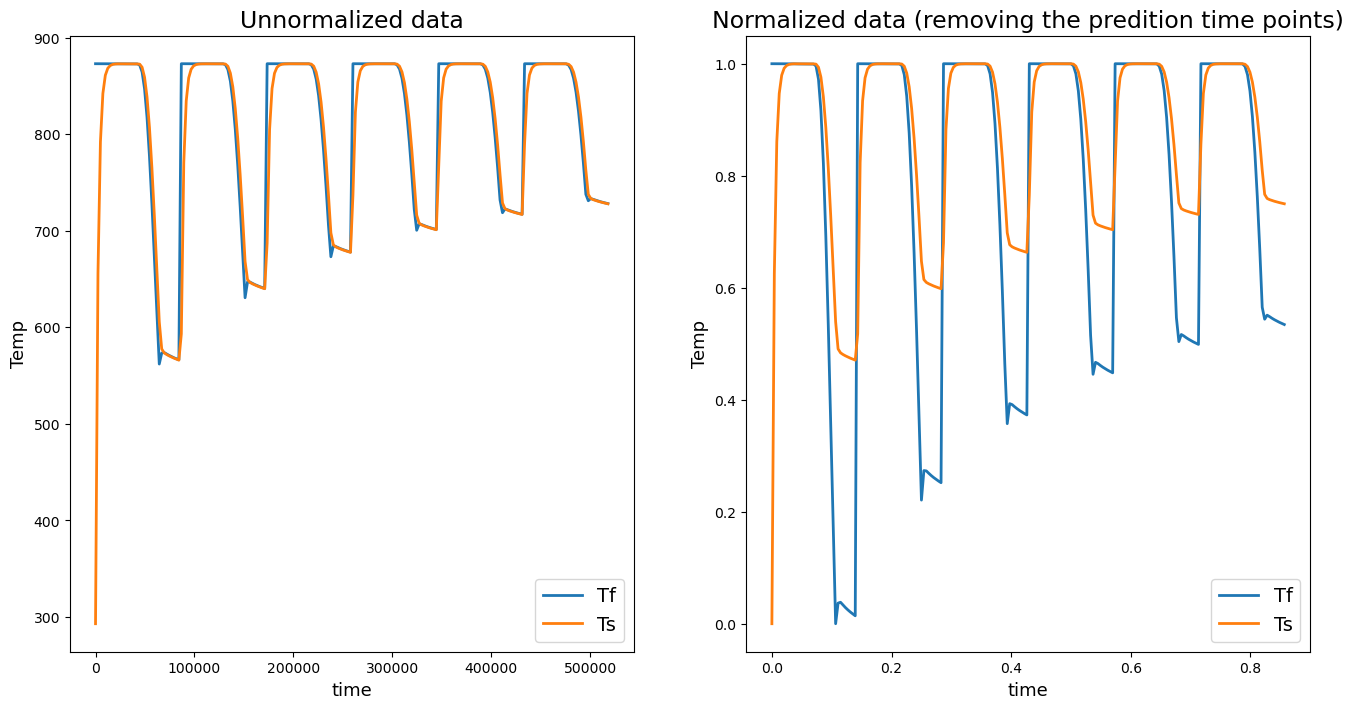

In [3]:
# Load the data from the file
df_data = pd.read_csv('TrainingData.txt')

pred_time = np.loadtxt('TestingData.txt', skiprows=1)
pred_time = np.append(pred_time, pred_time[-1]+(pred_time[1] - pred_time[0]))
pred_time = torch.from_numpy(pred_time).float()

# Unnormalized data
t_data = torch.tensor(df_data['t'].values, dtype=torch.float)
Tf_data = torch.tensor(df_data['tf0'].values, dtype=torch.float)
Ts_data = torch.tensor(df_data['ts0'].values, dtype=torch.float)

# Add the prediction time to the data
t_data = torch.cat([t_data, pred_time], dim=0)

# Normalized data
t_data_norm = (t_data - t_data.min()) / (t_data.max() - t_data.min())
Tf_data_norm = (Tf_data - Tf_data.min()) / (Tf_data.max() - Tf_data.min())
Ts_data_norm = (Ts_data - Ts_data.min()) / (Ts_data.max() - Ts_data.min())


# Plot the data
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# unnormalized data
axs[0].plot(t_data[:-35], Tf_data, label='Tf', linewidth=2)
axs[0].plot(t_data[:-35], Ts_data, label='Ts', linewidth=2)
axs[0].set_xlabel('time', size=13)
axs[0].set_ylabel('Temp', size=13)
axs[0].legend(fontsize=14)
axs[0].set_title('Unnormalized data', size=17)

# normalized data
axs[1].plot(t_data_norm[:-35], Tf_data_norm, label='Tf', linewidth=2)
axs[1].plot(t_data_norm[:-35], Ts_data_norm, label='Ts', linewidth=2)
axs[1].set_xlabel('time', size=13)
axs[1].set_ylabel('Temp', size=13)
axs[1].legend(fontsize=14)
axs[1].set_title('Normalized data (removing the predition time points)', size=17)
# axs[1].axvline(x=0.835, color='r', linestyle='--')  

### Prepare the data

In [4]:
# # Devide the data into training and testing
# train_perc = 1
# t_train = t_data_norm[:int(len(t_data)*train_perc)].reshape(-1)
# Tf_train = Tf_data_norm[:int(len(Tf_data)*train_perc)].reshape(-1)
# Ts_train = Ts_data_norm[:int(len(Ts_data)*train_perc)].reshape(-1)

# t_test = t_data_norm[int(len(t_data)*train_perc):].reshape(-1)
# Tf_test = Tf_data_norm[int(len(Tf_data)*train_perc):].reshape(-1)
# Ts_test = Ts_data_norm[int(len(Ts_data)*train_perc):].reshape(-1)

In [5]:
com_div = 35

input_Tf = torch.stack([Tf_data_norm.reshape(-1), t_data_norm[:-35].reshape(-1)], dim=1).reshape(-1, com_div, 2)  # we want (a(x), x) & remove prediction time points
input_Ts = torch.stack([Ts_data_norm.reshape(-1), t_data_norm[:-35].reshape(-1)], dim=1).reshape(-1, com_div, 2)  # we want (a(x), x) & remove prediction time points

print('input_Tf.shape', input_Tf.shape)
print('input_Ts.shape', input_Ts.shape)

input_train_Tf = input_Tf[:-1, :]
input_train_Ts = input_Ts[:-1, :]

output_train_Tf = input_Tf[1:, :, 0]
output_train_Ts = input_Ts[1:, :, 0]

print()
print('input_train_Tf.shape' ,input_train_Tf.shape)
print('output_train_Tf.shape', output_train_Tf.shape)
print()
print('input_train_Ts.shape', input_train_Ts.shape)
print('output_train_Ts.shape', output_train_Ts.shape)

# Define the batch size and load the Dataset
batch_size = 2

training_set_Tf = DataLoader(TensorDataset(input_train_Tf, output_train_Tf), batch_size=batch_size, shuffle=True)
training_set_Ts = DataLoader(TensorDataset(input_train_Ts, output_train_Ts), batch_size=batch_size, shuffle=True)

input_Tf.shape torch.Size([6, 35, 2])
input_Ts.shape torch.Size([6, 35, 2])

input_train_Tf.shape torch.Size([5, 35, 2])
output_train_Tf.shape torch.Size([5, 35])

input_train_Ts.shape torch.Size([5, 35, 2])
output_train_Ts.shape torch.Size([5, 35])


### Train the FNO

In [6]:
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 17
width = 256

# model

fno_Tf = FNO1d(modes, width)
fno_Ts = FNO1d(modes, width)

In [7]:
# Train the Tf FNO
optimizer_Tf = Adam(fno_Tf.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler_Tf = torch.optim.lr_scheduler.StepLR(optimizer_Tf, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Tf):
        optimizer_Tf.zero_grad()
        output_pred_batch = fno_Tf(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer_Tf.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Tf)

    scheduler_Tf.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:")


######### Epoch: 0  ######### Train Loss: 0.4617270976305008  ######### Relative L2 Test Norm:
######### Epoch: 10  ######### Train Loss: 0.004070760992666085  ######### Relative L2 Test Norm:
######### Epoch: 20  ######### Train Loss: 0.0004401408659759909  ######### Relative L2 Test Norm:
######### Epoch: 30  ######### Train Loss: 2.5829755031736568e-05  ######### Relative L2 Test Norm:
######### Epoch: 40  ######### Train Loss: 8.34903206244538e-06  ######### Relative L2 Test Norm:
######### Epoch: 50  ######### Train Loss: 9.684886663308134e-06  ######### Relative L2 Test Norm:
######### Epoch: 60  ######### Train Loss: 5.5546640093477135e-06  ######### Relative L2 Test Norm:
######### Epoch: 70  ######### Train Loss: 7.373824701062404e-06  ######### Relative L2 Test Norm:
######### Epoch: 80  ######### Train Loss: 5.406006190848227e-06  ######### Relative L2 Test Norm:
######### Epoch: 90  ######### Train Loss: 5.0619131191827664e-06  ######### Relative L2 Test Norm:
######### Epo

In [8]:
# Train the Ts FNO
optimizer_Ts = Adam(fno_Ts.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler_Ts = torch.optim.lr_scheduler.StepLR(optimizer_Ts, step_size=step_size, gamma=gamma)

l = torch.nn.MSELoss()
freq_print = 10
for epoch in range(epochs):
    train_mse = 0.0
    for step, (input_batch, output_batch) in enumerate(training_set_Ts):
        optimizer_Ts.zero_grad()
        output_pred_batch = fno_Ts(input_batch).squeeze(2)
        loss_f = l(output_pred_batch, output_batch)
        loss_f.backward()
        optimizer_Ts.step()
        train_mse += loss_f.item()
    train_mse /= len(training_set_Ts)

    scheduler_Ts.step()

    if epoch % freq_print == 0: print("######### Epoch:", epoch, " ######### Train Loss:", train_mse, " ######### Relative L2 Test Norm:")


######### Epoch: 0  ######### Train Loss: 0.3734979343911012  ######### Relative L2 Test Norm:
######### Epoch: 10  ######### Train Loss: 0.004725153907202184  ######### Relative L2 Test Norm:
######### Epoch: 20  ######### Train Loss: 0.00022278266260400414  ######### Relative L2 Test Norm:
######### Epoch: 30  ######### Train Loss: 3.297178591310512e-05  ######### Relative L2 Test Norm:
######### Epoch: 40  ######### Train Loss: 2.2415356397686992e-05  ######### Relative L2 Test Norm:
######### Epoch: 50  ######### Train Loss: 1.2148613980874265e-05  ######### Relative L2 Test Norm:
######### Epoch: 60  ######### Train Loss: 1.1039656328648562e-05  ######### Relative L2 Test Norm:
######### Epoch: 70  ######### Train Loss: 1.1003663682155699e-05  ######### Relative L2 Test Norm:
######### Epoch: 80  ######### Train Loss: 1.4098330666456604e-05  ######### Relative L2 Test Norm:
######### Epoch: 90  ######### Train Loss: 1.168465360024129e-05  ######### Relative L2 Test Norm:
#########

### Plot the trained part

Relative L2 error of Tf:  0.3062818646430969
Relative L2 error of Ts:  0.31251955032348633

Relative L2 error of Tf:  0.22148248553276062
Relative L2 error of Ts:  0.5148692727088928

Relative L2 error of Tf:  0.1440284103155136
Relative L2 error of Ts:  0.1720968335866928

Relative L2 error of Tf:  0.1466209441423416
Relative L2 error of Ts:  0.17626570165157318

Relative L2 error of Tf:  0.21117077767848969
Relative L2 error of Ts:  0.31239086389541626



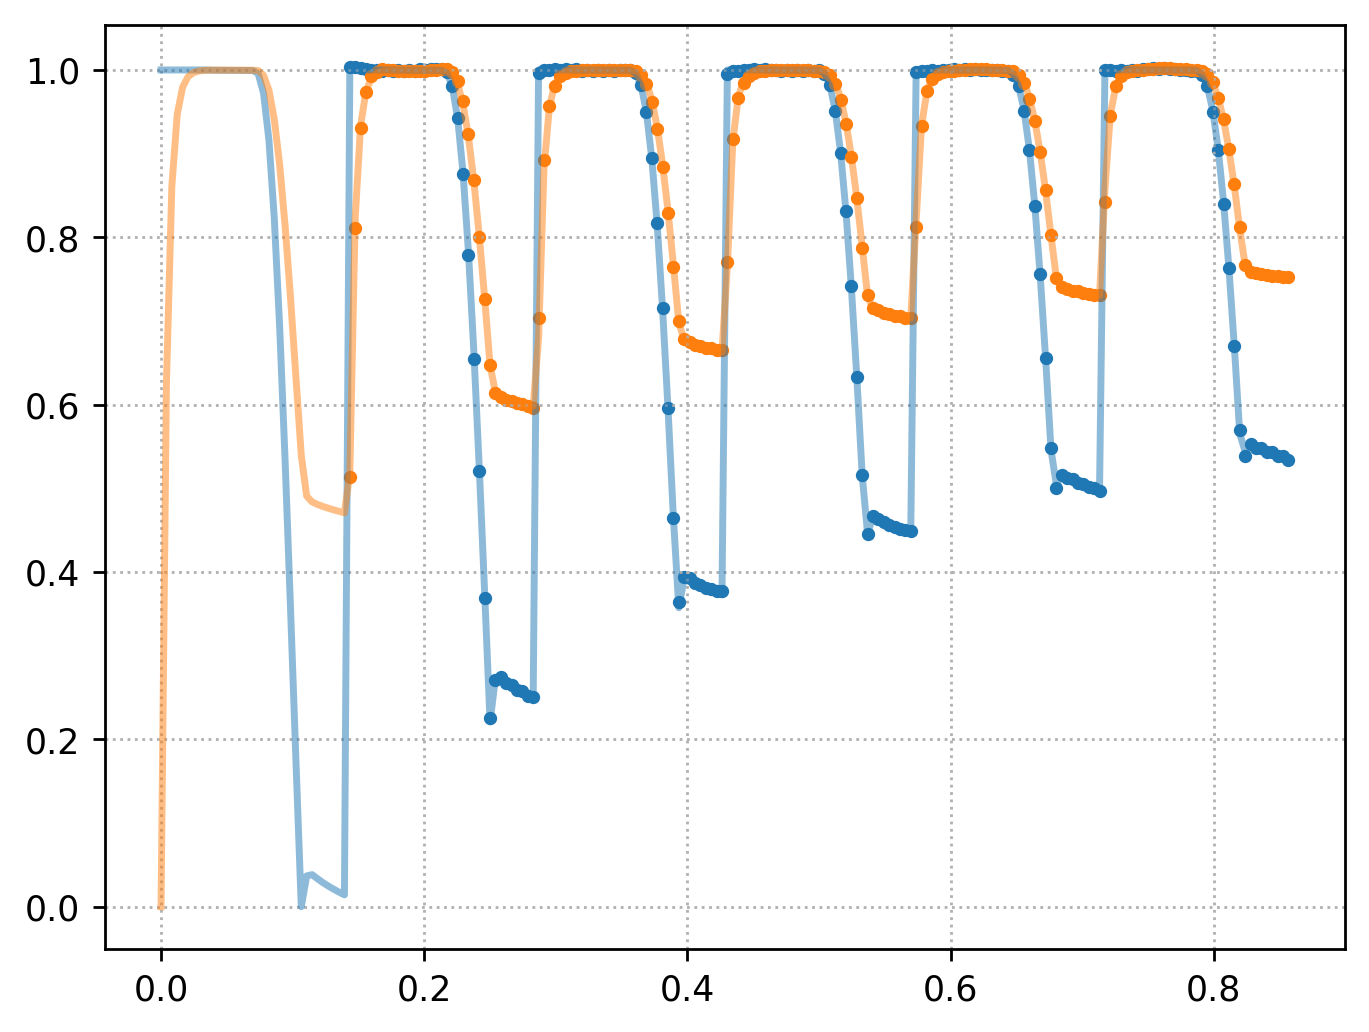

In [9]:
plt.figure(dpi=250)
plt.grid(True, which="both", ls=":")

# Plot fno_Tf & fno_Ts
assert input_Tf.shape[0] == input_Ts.shape[0]
plt.plot(t_data_norm[:-35], Tf_data_norm, label="True Solution", c="C0", lw=2, alpha=0.5)
plt.plot(t_data_norm[:-35], Ts_data_norm, label="True Solution", c="C1", lw=2, alpha=0.5)

for i in range(input_train_Tf.shape[0]):

    input_function_test_Tf = input_train_Tf[i, :].unsqueeze(0)
    output_function_test_Tf = output_train_Tf[i, :].unsqueeze(0)

    input_function_test_Ts = input_train_Ts[i, :].unsqueeze(0)
    output_function_test_Ts = output_train_Ts[i, :].unsqueeze(0)

    output_function_test_pred_Tf = fno_Tf(input_function_test_Tf)
    output_function_test_pred_Ts = fno_Ts(input_function_test_Ts)
    
    # plt.plot(input_Tf[i+1, :][:, 1].detach(), output_function_test_Tf[0].detach(), label="True Solution", c="C0", lw=2)
    plt.scatter(input_Tf[i+1, :][:, 1].detach(), output_function_test_pred_Tf[0].detach(), label="Approximate Solution", s=8, c="C0")

    # plt.plot(input_Ts[i+1, :][:, 1].detach(), output_function_test_Ts[0].detach(), label="True Solution", c="C1", lw=2)
    plt.scatter(input_Ts[i+1, :][:, 1].detach(), output_function_test_pred_Ts[0].detach(), label="Approximate Solution", s=8, c="C1")
    
    p = 2
    err_Tf = (torch.mean(abs(output_function_test_Tf.detach().reshape(-1, ) - output_function_test_pred_Tf.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_Tf.detach()) ** p)) ** (1 / p) * 100
    err_Ts = (torch.mean(abs(output_function_test_Ts.detach().reshape(-1, ) - output_function_test_pred_Ts.detach().reshape(-1, )) ** p) / torch.mean(abs(output_function_test_Ts.detach()) ** p)) ** (1 / p) * 100
    print("Relative L2 error of Tf: ", err_Tf.item())
    print("Relative L2 error of Ts: ", err_Ts.item())
    print()



### Make prediction

input_prfd_Tf.shape torch.Size([1, 35, 2])
input_prfd_Ts.shape torch.Size([1, 35, 2])


Text(0.5, 1.0, 'Normalized data')

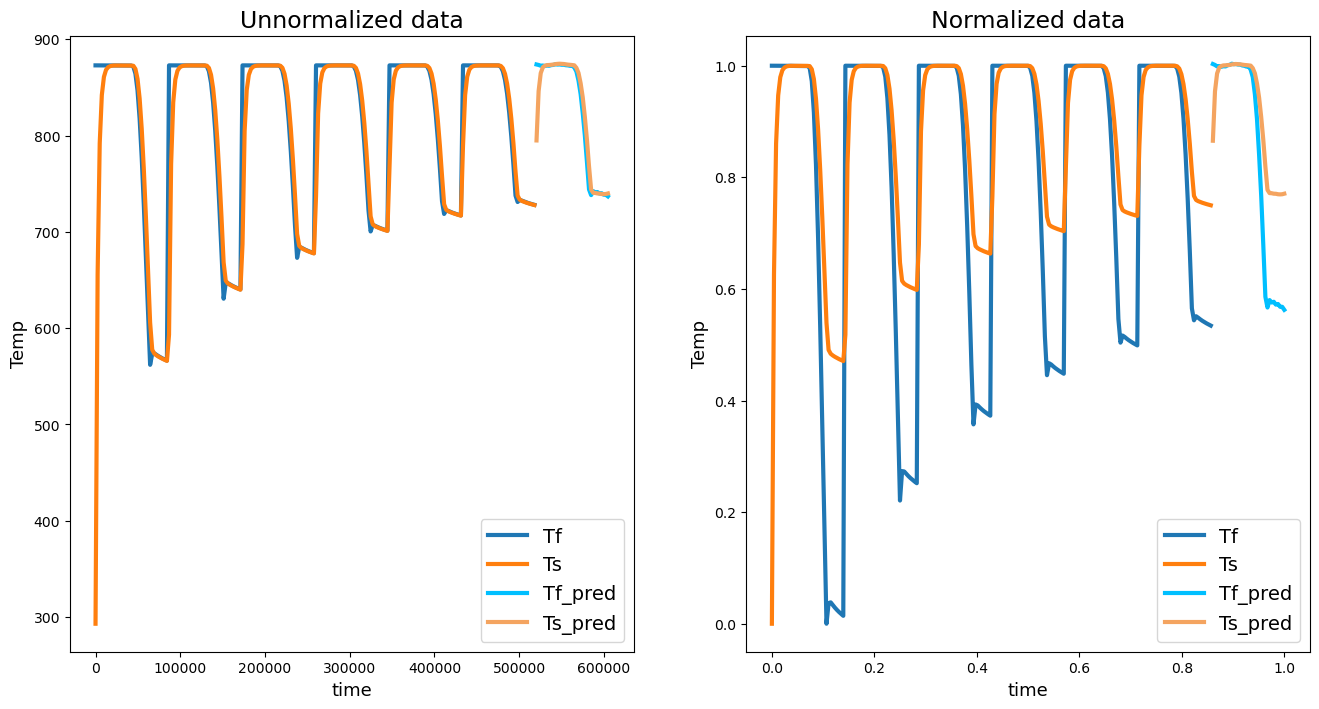

In [10]:
input_prfd_Tf = input_Tf[-1, :].unsqueeze(0)
input_prfd_Ts = input_Ts[-1, :].unsqueeze(0)

print('input_prfd_Tf.shape', input_prfd_Tf.shape)
print('input_prfd_Ts.shape', input_prfd_Ts.shape)

output_pred_Tf = fno_Tf(input_prfd_Tf).squeeze()
output_pred_Ts = fno_Ts(input_prfd_Ts).squeeze()

# Unnormalize the data
output_pred_Tf_unnorm = output_pred_Tf * (Tf_data.max() - Tf_data.min()) + Tf_data.min()
output_pred_Ts_unnorm = output_pred_Ts * (Ts_data.max() - Ts_data.min()) + Ts_data.min()

# Plot the prediction
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# unnormalized data
axs[0].plot(t_data[:-35], Tf_data, label='Tf', linewidth=3)
axs[0].plot(t_data[:-35], Ts_data, label='Ts', linewidth=3)

axs[0].plot(t_data[-35:], output_pred_Tf_unnorm.detach(), label='Tf_pred', c="deepskyblue", linewidth=3)
axs[0].plot(t_data[-35:], output_pred_Ts_unnorm.detach(), label='Ts_pred', c="sandybrown", linewidth=3)

axs[0].set_xlabel('time', size=13)
axs[0].set_ylabel('Temp', size=13)
axs[0].legend(fontsize=14)
axs[0].set_title('Unnormalized data', size=17)

# normalized data
axs[1].plot(t_data_norm[:-35], Tf_data_norm, label='Tf', linewidth=3)
axs[1].plot(t_data_norm[:-35], Ts_data_norm, label='Ts', linewidth=3)

axs[1].plot(t_data_norm[-35:], output_pred_Tf.detach(), label='Tf_pred', c="deepskyblue", linewidth=3)
axs[1].plot(t_data_norm[-35:], output_pred_Ts.detach(), label='Ts_pred', c="sandybrown", linewidth=3)

axs[1].set_xlabel('time', size=13)
axs[1].set_ylabel('Temp', size=13)
axs[1].legend(fontsize=14)
axs[1].set_title('Normalized data', size=17)

### Save the predictions

In [11]:
# Remove the extra point

assert output_pred_Tf_unnorm.shape[0] == output_pred_Ts_unnorm.shape[0] == 35
output_pred_Tf_unnorm_save = output_pred_Tf_unnorm[:-1]
output_pred_Ts_unnorm_save = output_pred_Ts_unnorm[:-1]
t_data_save = t_data[210:-1]

print('output_pred_Tf_unnorm_save.shape', output_pred_Tf_unnorm_save.shape)
print('output_pred_Ts_unnorm_save.shape', output_pred_Ts_unnorm_save.shape)
print('t_data_save.shape', t_data_save.shape)

df_save = pd.DataFrame({'t': t_data_save.detach().numpy(), 'tf0': output_pred_Tf_unnorm_save.detach().numpy(), 'ts0': output_pred_Ts_unnorm_save.detach().numpy()})
df_save.to_csv('Task3.txt', index=False)

output_pred_Tf_unnorm_save.shape torch.Size([34])
output_pred_Ts_unnorm_save.shape torch.Size([34])
t_data_save.shape torch.Size([34])
